In [148]:
%matplotlib inline

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.special import comb

In [150]:
# Global variables

# Queue size
MAX_QUEUE_SIZE = 20

# Arrival average of customers per unit time (Poisson process)
ARRIVAL_SIMPLE = 18
ARRIVAL_COMPLEX = 8

# Service rate of agents for each query types (Exponential distribution)
## Agent 1
SERVICE_SIMPLE_1 = 12
SERVICE_COMPLEX_1 = 3
## Agent 2
SERVICE_SIMPLE_2 = 6
SERVICE_COMPLEX_2 = 5

# Discount factor for future rewards
DISCOUNT = 0.95

# State space: (queue 1 size, queue 2 size, call type)
STATE_SPACE = (MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1, 2)
# State space size
# STATE_SIZE = np.prod(STATE_SPACE)

# Call type: 0 = simple, 1 = complex
CALL_TYPE = [0, 1]

# Actions: 0 = route to queue 1, 1 = route to queue 2
ACTIONS = [0, 1]

In [151]:
def calculate_transition_probabilities(q1, q2, action):
    """
    Calculate transition probabilities based on event rates
    """
    
    # Initialize rates based on queue conditions
    rate_simple_dep_1 = SERVICE_SIMPLE_1 if q1 > 0 else 0
    rate_complex_dep_1 = SERVICE_COMPLEX_1 if q1 > 0 else 0
    rate_simple_dep_2 = SERVICE_SIMPLE_2 if q2 > 0 else 0
    rate_complex_dep_2 = SERVICE_COMPLEX_2 if q2 > 0 else 0
    
    # Check if arrivals are possible (queues not full)
    queues_full = (q1 == MAX_QUEUE_SIZE and q2 == MAX_QUEUE_SIZE) or \
        ((q1 == MAX_QUEUE_SIZE and action == 0) or (q2 == MAX_QUEUE_SIZE and action == 1))
    rate_simple_arr = ARRIVAL_SIMPLE if not queues_full else 0
    rate_complex_arr = ARRIVAL_COMPLEX if not queues_full else 0
    
    # Calculate total rate after applying conditions
    total_rate = (rate_simple_dep_1 + rate_complex_dep_1 + 
                  rate_simple_dep_2 + rate_complex_dep_2 + 
                  rate_simple_arr + rate_complex_arr)
    
    # Calculate probabilities
    return {
        'simple_dep_1': rate_simple_dep_1 / total_rate,
        'complex_dep_1': rate_complex_dep_1 / total_rate,
        'simple_dep_2': rate_simple_dep_2 / total_rate,
        'complex_dep_2': rate_complex_dep_2 / total_rate,
        'simple_arr': rate_simple_arr / total_rate,
        'complex_arr': rate_complex_arr / total_rate
    }

def expected_waiting_time(state, action):
    """
    Expected waiting times accounting for all possible queue compositions
    """
    
    q1, q2, call_type = state
    
    wait = 0.0
    
    # Probability of call being simple or complex
    p_simple = ARRIVAL_SIMPLE / (ARRIVAL_SIMPLE + ARRIVAL_COMPLEX)
    p_complex = ARRIVAL_COMPLEX / (ARRIVAL_SIMPLE + ARRIVAL_COMPLEX)
    
    if action == 0:
        # Route to queue 1
        # Account for existing queue composition
        for k in range(q1 + 1):  # k is number of simple calls
            # Binomial probability of having k simple calls in queue of size q1
            if q1 > 0:
                prob = comb(q1, k) * (p_simple**k) * (p_complex**(q1-k))
                # Expected waiting time with this composition
                wait_k = (k / SERVICE_SIMPLE_1) + ((q1-k) / SERVICE_COMPLEX_1)
                wait += prob * wait_k
            
        # Add service time for current call
        if call_type == 0:  # Simple call
            wait += 1 / SERVICE_SIMPLE_1
        else:  # Complex call
            wait += 1 / SERVICE_COMPLEX_1
    else:
        # Route to queue 2 (similar calculation)
        for k in range(q2 + 1):
            if q2 > 0:
                prob = comb(q2, k) * (p_simple**k) * (p_complex**(q2-k))
                wait_k = (k / SERVICE_SIMPLE_2) + ((q2-k) / SERVICE_COMPLEX_2)
                wait += prob * wait_k
            
        if call_type == 0:
            wait += 1 / SERVICE_SIMPLE_2
        else:
            wait += 1 / SERVICE_COMPLEX_2
            
    return wait  # We don't negate this but use argmin

def expected_future_cost(action, value, q1, q2, call_type):
    """
    Calculate expected cost for the next state based on action taken
    """
    
    # Initialise expected next state value
    expected_next_cost = 0.0
    
    # Calculate next state based on action
    next_q1 = q1
    next_q2 = q2
    
    if action == 0:
        next_q1 = min(q1 + 1, MAX_QUEUE_SIZE)
    else:  # action == 1
        next_q2 = min(q2 + 1, MAX_QUEUE_SIZE)
        
    # Get transition probabilities
    trans_probs = calculate_transition_probabilities(next_q1, next_q2, action)
    
    # Consider all possible next events
    # 1. Departures from queue 1 (if queue not empty)
    if next_q1 > 0:
        next_state_val = value[next_q1-1, next_q2, call_type]
        expected_next_cost += trans_probs['simple_dep_1'] * next_state_val
        expected_next_cost += trans_probs['complex_dep_1'] * next_state_val
    
    # 3. Departures from queue 2 (if queue not empty)
    if next_q2 > 0:
        next_state_val = value[next_q1, next_q2-1, call_type]
        expected_next_cost += trans_probs['simple_dep_2'] * next_state_val
        expected_next_cost += trans_probs['complex_dep_2'] * next_state_val
    
    # 5. Simple arrival
    next_state_val = value[min(next_q1, MAX_QUEUE_SIZE), min(next_q2, MAX_QUEUE_SIZE), 0]
    expected_next_cost += trans_probs['simple_arr'] * next_state_val
    
    # 6. Complex arrival
    next_state_val = value[min(next_q1, MAX_QUEUE_SIZE), min(next_q2, MAX_QUEUE_SIZE), 1]
    expected_next_cost += trans_probs['complex_arr'] * next_state_val
    
    return expected_next_cost
    

In [152]:
def policy_evaluation(policy_simple, policy_complex, value, threshold=1e-4):
    """
    Evaluate the policy by calculating state values
    """
    
    while True:
        delta = 0
        
        old_value = value.copy()
        
        # For each state
        for q1 in range(MAX_QUEUE_SIZE + 1):
            for q2 in range(MAX_QUEUE_SIZE + 1):
                for call_type in CALL_TYPE:
                    # old_value = value[q1, q2, call_type]
                    
                    # Get action from policy
                    if call_type == 0:
                        action = policy_simple[q1, q2]
                    else:
                        action = policy_complex[q1, q2]
                        
                    
                    waiting_cost = expected_waiting_time((q1, q2, call_type), action)
                    
                    # Calculate expected next state value
                    expected_next_cost = expected_future_cost(action, value, q1, q2, call_type)
                        
                    # Update value function
                    value[q1, q2, call_type] = waiting_cost + DISCOUNT * expected_next_cost
                    
        # Track the maximum change in value
        delta = abs(old_value - value).max()
        
        print(f"Delta: {delta}")
        
        # Check for convergence
        if delta < threshold:
            break
    
    return value
                    
                    
def policy_improvement(value):
    """
    Improve policy based on current value function
    """
    
    policy_simple = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
    policy_complex = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
    
    # For each state
    for q1 in range(MAX_QUEUE_SIZE + 1):
        for q2 in range(MAX_QUEUE_SIZE + 1):
            # For simple calls
            action_values = []
            for action in ACTIONS:
                
                # Calculate expected waiting times
                waiting_cost = expected_waiting_time((q1, q2, 0), action)
                
                # Calculate next state based on action
                expected_next_cost = expected_future_cost(action, value, q1, q2, 0)
                
                action_values.append(waiting_cost + DISCOUNT * expected_next_cost)
                
            # print(action_values)
            
            # Choose the action with the minimum expected waiting time
            if len(action_values) > 0:
                policy_simple[q1, q2] = ACTIONS[np.argmin(action_values)]
            else:
                # Default action if all actions are invalid
                policy_simple[q1, q2] = 0
                
            # For complex calls
            action_values = []
            for action in ACTIONS:
                
                # Calculate expected waiting times
                waiting_cost = expected_waiting_time((q1, q2, 1), action)
                
                # Calculate next state based on action
                expected_next_cost = expected_future_cost(action, value, q1, q2, 1)
                
                action_values.append(waiting_cost + DISCOUNT * expected_next_cost)
            
            # Choose the action with the minimum expected waiting time
            if len(action_values) > 0:
                policy_complex[q1, q2] = ACTIONS[np.argmin(action_values)]
            else:
                # Default action if all actions are invalid
                policy_complex[q1, q2] = 1
    
    return policy_simple, policy_complex
                

Iteration 0
Delta: 9.012181520951003
Delta: 5.473719982489463
Delta: 5.016109652712091
Delta: 4.596754721004375
Delta: 4.225455531844755
Delta: 3.9254095360672494
Delta: 3.6864684393150853
Delta: 3.4778793399381946
Delta: 3.260596666979893
Delta: 3.0879945429460918
Delta: 2.9184177453287035
Delta: 2.7416730500731497
Delta: 2.604261838083186
Delta: 2.4620609105004903
Delta: 2.3186919198476303
Delta: 2.2020473619929746
Delta: 2.0828113813370237
Delta: 1.9638003914653908
Delta: 1.8650528918254494
Delta: 1.7650983984751392
Delta: 1.6648699400830793
Delta: 1.58145769278293
Delta: 1.497617439274169
Delta: 1.4138096298465648
Delta: 1.3420296601293238
Delta: 1.2716433367771138
Delta: 1.2015866706937715
Delta: 1.1393762531457092
Delta: 1.0802322527935182
Delta: 1.0215625535485877
Delta: 0.9674915408078704
Delta: 0.9177564058558545
Delta: 0.8637207425967119
Delta: 0.8052299877154638
Delta: 0.7452516368363931
Delta: 0.6859264167172796
Delta: 0.6286622053759885
Delta: 0.5743012196505539
Delta: 0.5

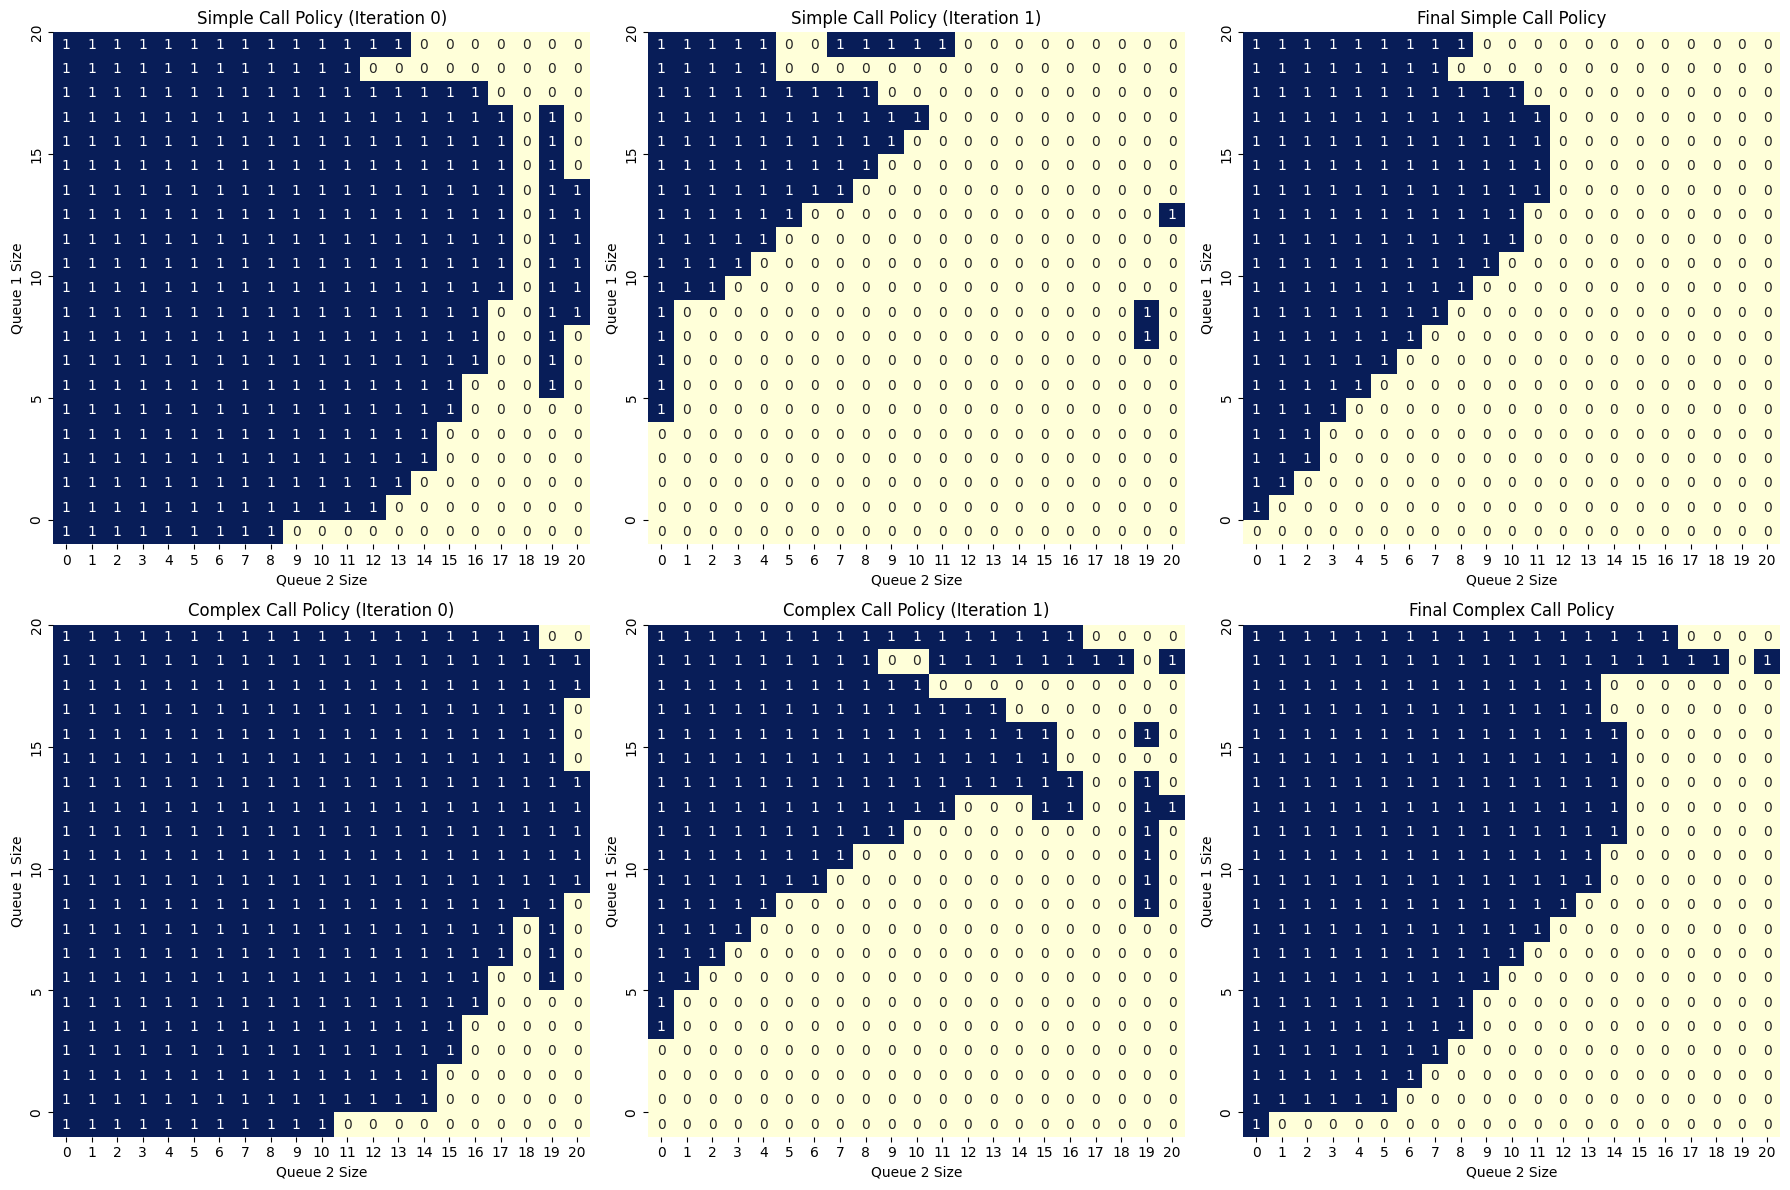

In [ ]:
# Run policy iteration algorithm

# Initialise policies
policy_simple = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
policy_complex = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)

# Initialise value function
value = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1, 2))

# For visualisation
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
iteration = 0
max_iterations = 10

while iteration < max_iterations:
    print(f"Iteration {iteration}")
    
    # Policy iteration
    # Policy evaluation
    value = policy_evaluation(policy_simple, policy_complex, value)
    
    # Policy improvement
    new_policy_simple, new_policy_complex = policy_improvement(value)
    
    # Check if policies have changed
    if np.array_equal(policy_simple, new_policy_simple) and np.array_equal(policy_complex, new_policy_complex):
        print("Policies have converged")
        policy_simple, policy_complex = new_policy_simple, new_policy_complex
        break
    
    policy_simple, policy_complex = new_policy_simple, new_policy_complex
    
    # Visualise current policies
    if iteration < 2:
        # Simple call policy
        sns.heatmap(np.flipud(policy_simple), cmap="YlGnBu", ax=axes[0, iteration], annot=np.flipud(policy_simple),
                    cbar=False, cbar_kws={'label': 'Action (0=Queue 1, 1=Queue 2)'})
        axes[0, iteration].set_title(f'Simple Call Policy (Iteration {iteration})')
        axes[0, iteration].set_ylabel('Queue 1 Size')
        axes[0, iteration].set_xlabel('Queue 2 Size')
        axes[0, iteration].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
        axes[0, iteration].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))
        
        # Complex call policy
        sns.heatmap(np.flipud(policy_complex), cmap="YlGnBu", ax=axes[1, iteration], annot=np.flipud(policy_complex),
                    cbar=False, cbar_kws={'label': 'Action (0=Queue 1, 1=Queue 2)'})
        axes[1, iteration].set_title(f'Complex Call Policy (Iteration {iteration})')
        axes[1, iteration].set_ylabel('Queue 1 Size')
        axes[1, iteration].set_xlabel('Queue 2 Size')
        axes[1, iteration].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
        axes[1, iteration].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))
    
    iteration += 1
    
# Final policies visualisation
# Simple call policy
sns.heatmap(np.flipud(policy_simple), cmap="YlGnBu", ax=axes[0, 2], annot=np.flipud(policy_simple),
            cbar=False, cbar_kws={'label': 'Action (0=Queue 1, 1=Queue 2)'})
axes[0, 2].set_title('Final Simple Call Policy')
axes[0, 2].set_ylabel('Queue 1 Size')
axes[0, 2].set_xlabel('Queue 2 Size')
axes[0, 2].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
axes[0, 2].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))

# Complex call policy
sns.heatmap(np.flipud(policy_complex), cmap="YlGnBu", ax=axes[1, 2], annot=np.flipud(policy_complex),
            cbar=False, cbar_kws={'label': 'Action (0=Queue 1, 1=Queue 2)'})
axes[1, 2].set_title('Final Complex Call Policy')
axes[1, 2].set_ylabel('Queue 1 Size')
axes[1, 2].set_xlabel('Queue 2 Size')
axes[1, 2].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
axes[1, 2].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))

plt.tight_layout()
plt.show()

In [154]:
# Save the policies to pickles

with open('policy_simple.pkl', 'wb') as f:
    pickle.dump(policy_simple, f)
    
with open('policy_complex.pkl', 'wb') as f:
    pickle.dump(policy_complex, f)

### What to implement next:

* Save policies into pickles ✅
* Simulation using the optimal policies
* Comparison between optimal policies with another policies
* (?) Update proportion based on simulation ❌ (canceled because we no longer use proportions)